# Clustering Astronomical Sources

The objective of this hands-on activity is to cluster a set of candidate sources from the Zwicky Transient Facility's (ZTF) image subtraction pipeline.  All candidate features and postage stamps were extracted from ZTF's public alert stream. 

The goal of this exercise is to become familiar with the ZTF data, the examination of some of its features, and running sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithm on 2 or more features.  Here are the steps we will take:

1. Load data
2. Plot Features 'elong' and 'chipsf'
3. Run KMeans on 2 Features
4. Feature Scaling
4. Evaluation Results Quantitatively
5. Evaluate Results by Examining Postage Stamps
6. Clustering in a Dimensionally-Reduced Space


### 0a. Imports

These are all the imports that will be used in this notebook.  All should be available in the DSFP conda environment.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from time import time
from matplotlib.pyplot import imshow
from matplotlib.image import imread
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances

### 0b. Data Location

You will need the following files:
- [dsfp_ztf_meta.npy](https://northwestern.box.com/s/ssnzcfjp4xggu7q2jgrmgrduy4de48w1)
- [dsfp_ztf_feats.npy](https://northwestern.box.com/s/2b4bdtqkv9v8b9ooginyx0wkmgnyi8nc)
- [dsfp_ztf_png_stamps.tar.gz](https://northwestern.box.com/s/pcx3hks09qwbi2tn1nokbmy8tkzk4btv)

You will need to unzip and unpack this last file (a "tarball") called `dsfp_ztf_png_stamps.tar.gz`. Run the following commands in the same directory as this notebook to unpack everything (note - some operating systems automatically unzip downloaded files):

 - gunzip dsfp_ztf_png_stamps.tar.gz
 - tar -xvf dsfp_ztf_png_stamps.tar
 
You should now have a directory in your current working directory (cwd) called dsfp_ztf_png_stamps.

Please specify the following file locations:


In [65]:
!ls


Clustering-Astronomical-Sources.ipynb dsfp_ztf_meta.npy
README.md                             dsfp_ztf_png_stamps
dsfp_ztf_feats.npy                    dsfp_ztf_png_stamps.tar.gz


In [66]:
F_META = '/Users/ioanaciuca/Desktop/MasterFolder/LSSTC/LSSTC-DSFP-Sessions/Session7/Day2/dsfp_ztf_meta.npy'
F_FEATS = '/Users/ioanaciuca/Desktop/MasterFolder/LSSTC/LSSTC-DSFP-Sessions/Session7/Day2/dsfp_ztf_feats.npy'
D_STAMPS = '/Users/ioanaciuca/Desktop/MasterFolder/LSSTC/LSSTC-DSFP-Sessions/Session7/Day2/dsfp_ztf_png_stamps/'


## 1. Load Data

We are ready to get started! :)  Start by loading the data and confirming that feats has the same number of columns as COL_NAMES.  Please note that the last columns is a class label with values {0, 1}, where 0=bogus, and 1=real.  Today we are doing unsupervised learning, but some clustering evaluation methods use labels to quantitatively measure the quality of the clustering result.

In [14]:
meta = np.load(F_META)
feats = np.load(F_FEATS)

COL_NAMES = ['diffmaglim', 'magpsf', 'sigmapsf', 'chipsf', 'magap', 'sigmagap',
             'distnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr', 'sky',
             'magdiff', 'fwhm', 'classtar', 'mindtoedge', 'magfromlim', 'seeratio',
             'aimage', 'bimage', 'aimagerat', 'bimagerat', 'elong', 'nneg',
             'nbad', 'ssdistnr', 'ssmagnr', 'sumrat', 'magapbig', 'sigmagapbig',
             'ndethist', 'ncovhist', 'jdstarthist', 'jdendhist', 'scorr', 'label']
             
# INSTRUCTION: Verify that feats has the same number of columns as COL_NAMES

print(len(feats[:,35]))

print(len(COL_NAMES))

3190
36


## 2. Plot Features

We will perform K-means clustering using two features: 'chipsf' and 'elong'.  Chipsf is the uncertainty associated with performing PSF-fit photometry.  The higher the chi values, the more uncertainty associated with the source's PSF fit. Elong is a measure of how elongated the source is.  A transient point source should have a spherical point spread function.  An elongated point source may be a sign of a problem with image subtraction.

Extract features chipsf and along from the data.  Scatter plot them together, and also plot their histograms.  

#### Question: What do you notice about these features?


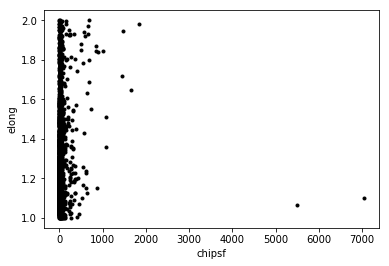

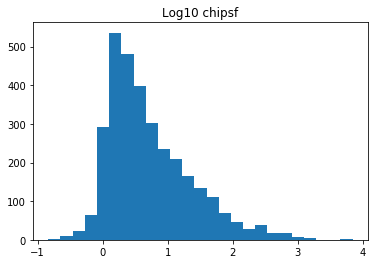

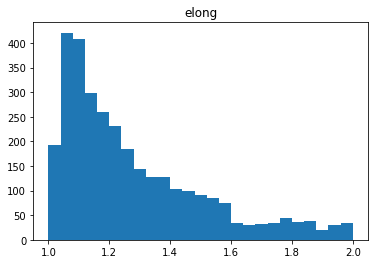

In [32]:
featnames_to_select = ['chipsf', 'elong']

# Extract the Correct Features
# 
featidxs_to_select_indices = [ COL_NAMES.index(x) for x in featnames_to_select]
feats_selected = feats[:,featidxs_to_select_indices]

# Scatter Plot the Two Features
#
def plot_scatter(dat, xlabel, ylabel, xscale='linear', yscale='linear'):
    plt.plot(dat[:,0], dat[:,1], 'k.')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.show()
    
# Scatter Plot the Two Features
#
def plot_histogram(dat, bins, title, xscale='linear', yscale='linear'):
    plt.hist(dat, bins)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(title)
    plt.show()

# INSTRUCTION: Scatter Plot the Data
# 
plot_scatter(feats_selected,  featnames_to_select[0], featnames_to_select[1])
# INSTRUCTION: Plot the Histograms for both features.  Hint, it may be helpful to plot some features on a log scale.
#
plot_histogram(np.log10(feats_selected[:, 0]), bins = 25, title = 'Log10 chipsf')
plot_histogram(feats_selected[:, 1], bins = 25, title = 'elong')

## 3. KMeans Using Two Features

We rarely ever cluster only two features from a dataset.  However, the advantage of doing so is that we can readily visualize two-dimensional data.  Let's start off by clustering features elong and chipsf with KMeans.  The plotKMeans function below implements a visualization of KMean's partitioning that was used in sklearn's [KMean's demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html).  

#### Question: What do you think about the quality of the clusterings produced?

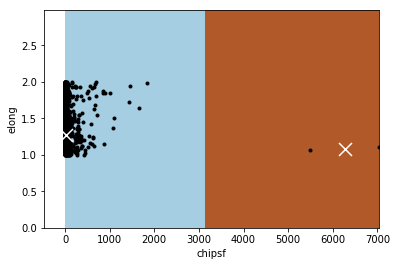

In [28]:

def runKMeans(dat, n_clusters=2, seed=0):
        return KMeans(n_clusters, random_state=seed).fit(dat) 

def plotKMeans(kmeans_res, reduced_dat, xlabel, ylabel, xscale='linear', yscale='linear'):
    
    # Plot the decision boundary. For that, we will assign a color to each
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = reduced_dat[:, 0].min() - 1, reduced_dat[:, 0].max() + 1
    y_min, y_max = reduced_dat[:, 1].min() - 1, reduced_dat[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans_res.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')
    plt.plot(reduced_dat[:,0], reduced_dat[:,1], 'k.')
    plt.scatter(kmeans_res.cluster_centers_[:, 0], kmeans_res.cluster_centers_[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.show()

# INSTRUCTION: Use the runKMeans and plotKMeans functions to cluster the data (feats_selected)
# with several values of k.  
kmeans_res = runKMeans(feats_selected, n_clusters=2, seed=0)
plotKMeans(kmeans_res, feats_selected, featnames_to_select[0], featnames_to_select[1],  xscale='linear', yscale='linear')


# 4. Feature Scaling

We just discovered that distance metrics can be sensitive to the scale of your data (e.g., some features span large numeric ranges, but others don't).  For machine learning methods that calculate similiarty between feature vectors, it is important to normalize data within a standard range such as (0, 1) or with z-score normalization (scaling to unit mean and variance).  Fortunately, sklearn also makes this quite easy.  Please review sklearn's [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) module options, specifically StandardScaler which corresponds to z-score normalization and MinMaxScaler.  Please implement one. 

After your data has been scaled, scatter plot your rescaled features, and run KMeans with the transformed data.  Compare the results on the transformed data with those above.

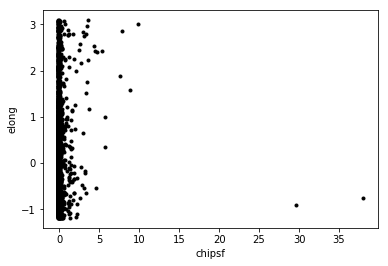

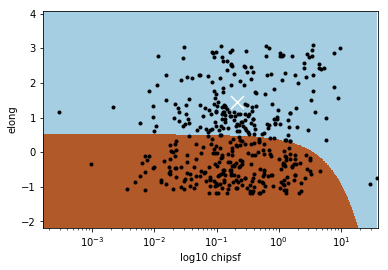

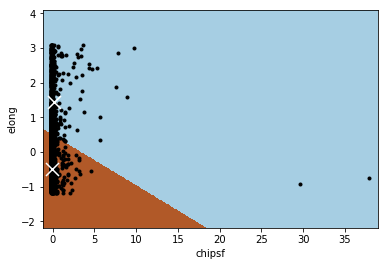

In [49]:
# INSTRUCTION: Re-scale your data using either the MinMaxScaler or StandardScaler from sklearn
#
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(feats_selected)
plot_scatter(scaled_data,featnames_to_select[0], featnames_to_select[1], xscale = 'linear', yscale = 'linear')
kmeans_res = runKMeans(scaled_data, n_clusters=2, seed=0)
plotKMeans(kmeans_res, scaled_data, 'log10 '+ featnames_to_select[0], featnames_to_select[1],  xscale='log', yscale='linear')
plotKMeans(kmeans_res, scaled_data,  featnames_to_select[0], featnames_to_select[1],  xscale='linear', yscale='linear')


# 5. Quantitative Cluster Evaluation

So far, we've been visually verifying our clusters.  Let's use quantitative methods to verify our results. 

The following is a score that does not require labels:
- inertia: "Sum of squared distances of samples to their closest cluster center."
- Silhouette coefficient: Measures minimal inertia in ratio to distance to next nearest cluster.  The score is higher are clusters become more compact and well-separated.

The following scores do require labels, and are documented [here](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation).

- ARI, AMI measure the similarity between ground_truth labels and predicted_labels.  ARI measure similarity, and AMI measures in terms of mutual information. Random assignments score close to 0, correct assignments close to 1.
- homogeneity: purity of the cluster (did all cluster members have the same label?). Scores in [0,1] where 0 is bad.
- completeness: did all labels cluster together in a single cluster? Scores in [0,1] where 0 is bad.


In [51]:
sample_size = 300
from sklearn import metrics
def bench_k_means(estimator, name, data, labels):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

labels = feats[:,-1]
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

# INSTRUCTIONS: Use the bench_k_means method to compare your clustering results
#
bench_k_means(KMeans(n_clusters=2, random_state=0), 'K-means on scaled data', scaled_data, labels)
bench_k_means(KMeans(n_clusters=2, random_state=0), 'K-means on unscaled data', scaled_data, labels)


__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
K-means on scaled data	0.04s	4047	0.109	0.111	0.110	-0.058	0.108	0.649
K-means on unscaled data	0.05s	4047	0.109	0.111	0.110	-0.058	0.108	0.628


In [40]:
len(labels)

3190

# 6.  Cluster Evaluation by Visual Inspection

## This time with postage stamps!

It can be tempting to let yourself be guided by metrics alone, and the metrics are useful guideposts that can help determine whether you're moving in the right direction.  However, the goal of clustering is to reveal structure in your dataset.  Fortunately, because the features were extracted from sources that were extracted from images, we can view the cutouts from each source to visually verify whether our clusters contain homogeneous objects.  

The display methods below give you an opportunity to display random candidates from each cluster, or the candidates that are closest to the cluster center.

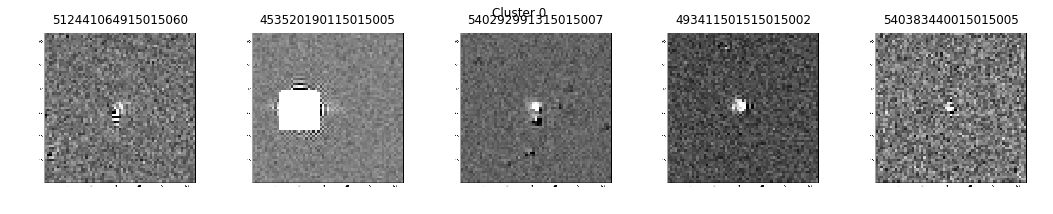

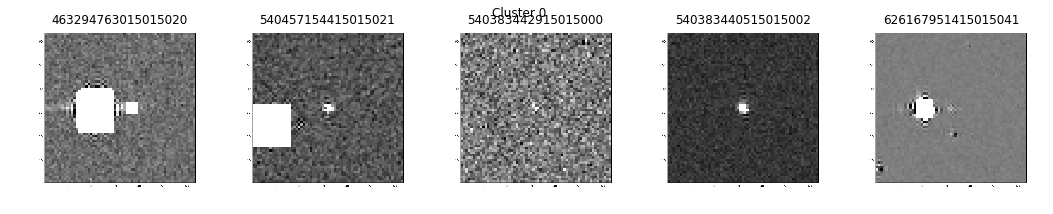

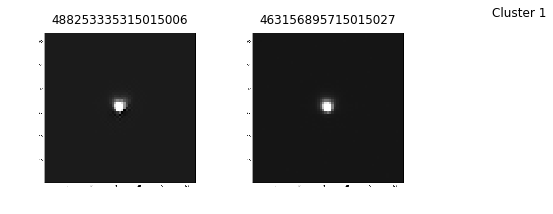

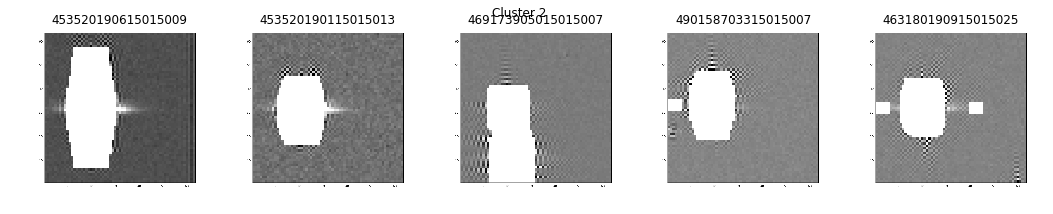

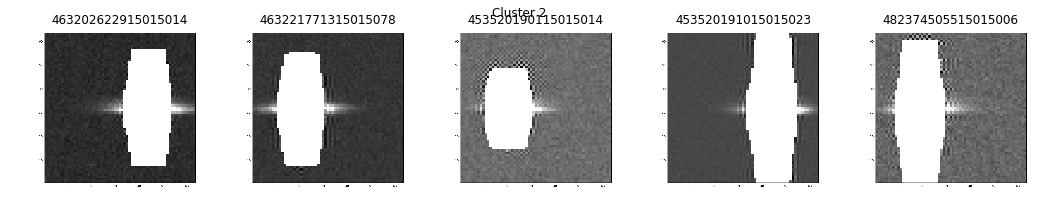

In [68]:
scaler = StandardScaler()
feats_selected_scaled = scaler.fit_transform(feats_selected)

def display_stamps(candids, fig_title):
    
    # display five across
    num_per_row = 5
    
    for i, candid in enumerate(candids):
        f_stamp = glob.glob(os.path.join(D_STAMPS, 'candid{}*.png'.format(candid)))[0] # there should only be one file returned!
        if (i % num_per_row) == 0:
            fig = plt.figure(figsize=(18, 3))
            fig.suptitle(fig_title)        

        ax = fig.add_subplot(1, num_per_row, i%num_per_row + 1)
        ax.set_axis_off()
        ax.set_title(candid)
        stamp = imread(f_stamp)
        imshow(stamp)
    return

def closest_to_centroid(centroid, cluster_feats, cluster_candids):
    
    dists = euclidean_distances(cluster_feats, centroid.reshape(1, -1))[:,0]
    closest_indices = np.argsort(dists)[:10]
    return cluster_candids[closest_indices]

def show_cluster_stamps(kmeans_res, feats_selected_scaled, displayMode='closest', num_to_display=10):
    # spits out a random selection of stamps from each cluster
    
    
    for i in range(kmeans_res.n_clusters):
        centroid = kmeans_res.cluster_centers_[i, :]
        mask = kmeans_res.labels_ == i
        cluster_candids = meta[mask]['candid']


        cluster_feats = feats_selected_scaled[mask]
        if displayMode == 'near_centroid':
            selected_candids = closest_to_centroid(centroid, cluster_feats, cluster_candids)
        if displayMode == 'random':
            np.random.shuffle(cluster_candids)
            selected_candids = cluster_candids[:num_to_display]
            
        display_stamps(selected_candids, 'Cluster {}'.format(i))

# INSTRUCTION: Use the show_cluster_stamps method to display cutouts associated with each cluster.
# Do you see similar objects in each cluster?
#
show_cluster_stamps(runKMeans(feats_selected_scaled, n_clusters=3, seed=0), feats_selected_scaled, displayMode='near_centroid',  num_to_display=10 
            )


# 7.  Clustering in a Dimensionally-Reduced Space

Given the tools seen above, starting clustering more than 2 features at a time.  This work is free-form.  I'll start you off with some suggested features.  After plotting the feature distributions, you may choose to down-select further.

Because we're now working with more than 2 features, use PCA to project the feature space onto its first two principal components.  You may use the methods above to run KMeans in that reduced feature space and evaluate your results.

In [ ]:
featnames_to_select = ['chipsf', 'elong', 'diffmaglim', 'magpsf', 'sigmapsf', 
                       'chipsf', 'magap', 'sigmagap', 'sky', 'magdiff', 'fwhm', 
                       'mindtoedge', 'magfromlim', 'seeratio', 'aimage', 'bimage',
                       'aimagerat', 'bimagerat', 'elong', 'nneg', 'nbad', 'sumrat', 'magapbig', 'sigmagapbig']

# INSTRUCTION: Visualize these features.  Discard any you consider to be problematic.

# INSTRUCTION: Filter the feature space

# INSTRUCTION: Run PCA on this feature space to reduce it to 2 principal components

# INSTRUCTION: Run KMeans on this 2-dimensional PCA space, and evaluate your results both quantatively and qualitatively.

#What type of feature should you discard? Extreme values should not be used?
# Choose to filter extreme value features - you can leave some objects out...
# Pick out the features. Run PCA, do the clustering.
# PCA is esentially trying to maximise the variance in your data. Noisy feature -> might not want to include it.
# FWHM want to be in the double digit... So data quality check is very important.
# Feature importance ? -> Random Forrest is a good option.